## Prerequisites

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2

import glob

2022-02-01 22:41:07.214369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 22:41:07.214417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# Importing data

In [4]:
train_mask = glob.glob('data/train/mask/*.jpg')
train_no_mask = glob.glob('data/train/no_mask/*.jpg')
test_mask = glob.glob('data/test/mask/*.jpg')
test_no_mask = glob.glob('data/test/no_mask/*.jpg')

In [5]:
np.random.shuffle(train_mask)
np.random.shuffle(train_no_mask)

In [6]:
val_mask = train_mask[500:]
val_no_mask = train_mask[500:]

train_mask = train_mask[:500]
train_no_mask = train_no_mask[:500]

X_train = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in train_mask + train_no_mask])
y_train = np.array([label for label in ['mask'] * len(train_mask) + ['no_mask'] * len(train_no_mask)])

X_val = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in val_mask + val_no_mask])
y_val = np.array([label for label in ['mask'] * len(val_mask) + ['no_mask'] * len(val_no_mask)])

X_test = np.array([preprocess_input(img_to_array(load_img(img, target_size=(224, 224)))) for img in test_mask + test_no_mask])
y_test = np.array([label for label in ['mask'] * len(test_mask) + ['no_mask'] * len(test_no_mask)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


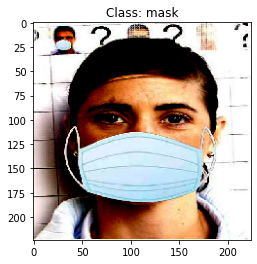

In [7]:
plt.imshow(X_train[77])
plt.title("Class: " + y_train[77])
plt.show()

In [8]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(y_train.reshape(-1,1))

y_train = ohe.transform(y_train.reshape(-1,1)).toarray()
y_val = ohe.transform(y_val.reshape(-1,1)).toarray()
y_test = ohe.transform(y_test.reshape(-1,1)).toarray()

In [9]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [10]:
X_train.shape

(1000, 224, 224, 3)

In [11]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [12]:
baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=(224, 224, 3)))

2022-02-01 22:41:57.383193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wojtek/anaconda3/envs/cv/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-01 22:41:57.400164: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-01 22:41:57.400225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wojtek-Vostro-5568): /proc/driver/nvidia/version does not exist
2022-02-01 22:41:57.401155: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9420800/9406464 [==============================] - 27s 3us/step


In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [14]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [15]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [15]:
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Epoch 1/10
10/31 [========>.....................] - ETA: 8s - loss: 0.7684 - accuracy: 0.6031

KeyboardInterrupt: 

In [ ]:
model.save("mask_detector.model", save_format="h5")

In [16]:
predIdxs = model.predict(X_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=("mask","no_mask")))

              precision    recall  f1-score   support

        mask       0.83      1.00      0.91        97
     no_mask       1.00      0.79      0.89        97

    accuracy                           0.90       194
   macro avg       0.91      0.90      0.90       194
weighted avg       0.91      0.90      0.90       194



In [17]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

NameError: name 'H' is not defined

<Figure size 432x288 with 0 Axes>

In [2]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

2022-02-02 17:07:06.309225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-02 17:07:06.309333: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
prototxtPath = os.path.sep.join(["deploy.prototxt.txt"])
weightsPath = os.path.sep.join(["res10_300x300_ssd_iter_140000.caffemodel"])

In [4]:
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [5]:
model = load_model("mask_detector.model")

2022-02-02 17:07:24.916031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wojtek/anaconda3/envs/cv/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-02 17:07:24.916112: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-02 17:07:24.916183: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wojtek-Vostro-5568): /proc/driver/nvidia/version does not exist
2022-02-02 17:07:24.916999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
image = cv2.imread("./data/train/no_mask/288.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


In [ ]:
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.90:
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

QObject::moveToThread: Current thread (0x55751bc05110) is not the object's thread (0x55751bb5c2d0).
Cannot move to target thread (0x55751bc05110)

QObject::moveToThread: Current thread (0x55751bc05110) is not the object's thread (0x55751bb5c2d0).
Cannot move to target thread (0x55751bc05110)

QObject::moveToThread: Current thread (0x55751bc05110) is not the object's thread (0x55751bb5c2d0).
Cannot move to target thread (0x55751bc05110)

QObject::moveToThread: Current thread (0x55751bc05110) is not the object's thread (0x55751bb5c2d0).
Cannot move to target thread (0x55751bc05110)

QObject::moveToThread: Current thread (0x55751bc05110) is not the object's thread (0x55751bb5c2d0).
Cannot move to target thread (0x55751bc05110)

QObject::moveToThread: Current thread (0x55751bc05110) is not the object's thread (0x55751bb5c2d0).
Cannot move to target thread (0x55751bc05110)

QObject::moveToThread: Current thread (0x55751bc05110) is not the object's thread (0x55751bb5c2d0).
Cannot move to tar

In [ ]:
image = cv2.imread("./data/train/no_mask/288.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

In [1]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2

In [2]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [3]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [5]:
image = cv2.imread('./data/face.jpg')
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# detect faces in the grayscale image
rects = detector(gray, 1)

In [6]:
shape = predictor(gray, rects[0])
shape = face_utils.shape_to_np(shape)
shape

array([[ 72, 245],
       [ 78, 274],
       [ 87, 303],
       [ 96, 330],
       [107, 356],
       [126, 376],
       [152, 390],
       [184, 395],
       [221, 393],
       [259, 387],
       [288, 377],
       [311, 358],
       [325, 334],
       [330, 303],
       [331, 271],
       [334, 240],
       [334, 210],
       [ 85, 195],
       [ 97, 172],
       [119, 159],
       [147, 155],
       [174, 156],
       [204, 152],
       [231, 143],
       [259, 141],
       [285, 146],
       [305, 164],
       [191, 178],
       [193, 191],
       [194, 203],
       [196, 217],
       [172, 255],
       [187, 253],
       [202, 252],
       [217, 249],
       [231, 247],
       [110, 208],
       [123, 197],
       [139, 193],
       [158, 200],
       [142, 205],
       [125, 208],
       [233, 189],
       [249, 178],
       [266, 177],
       [281, 184],
       [268, 188],
       [251, 189],
       [159, 308],
       [174, 288],
       [190, 277],
       [205, 278],
       [220,

In [7]:
coords = shape[[0, 8, 16]]
coords

array([[ 72, 245],
       [221, 393],
       [334, 210]])

In [8]:
coords[2] - coords[0]

array([262, -35])

In [11]:
import matplotlib.pyplot as plt

In [13]:
diff = coords[2] - coords[0]

width = int(sum((diff) ** 2) ** (1/2))
mid = (coords[0] + coords[2]) / 2
height = int(sum((mid - coords[1]) ** 2) ** (1/2))

angle = np.degrees(np.arctan2(diff[1], diff[0]))

print(width, height, angle)

264 166 -7.6089673131713


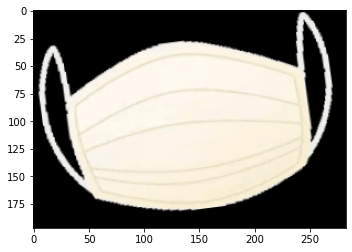

In [14]:
s_img = cv2.imread("./data/mask.png")
s_img = imutils.resize(s_img, width=width, height=height)
s_img = imutils.rotate_bound(s_img, angle)
plt.imshow(s_img)

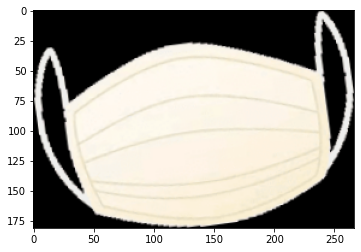

In [15]:
img = s_img.copy()

rows = [i for i, row in enumerate(s_img) if row.sum() == 0]
columns = [i for i, col in enumerate(s_img.transpose(1, 0, 2)) if col.sum() == 0]
        
img = np.delete(img, [rows], 0)
img = np.delete(img.transpose(1, 0, 2), [columns], 0)
img = img.transpose(1, 0, 2)
plt.imshow(img)

In [117]:
l_img = cv2.imread("./data/train/no_mask/3.jpg")

In [118]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
gray = cv2.cvtColor(l_img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)
shape = predictor(gray, rects[0])
shape = face_utils.shape_to_np(shape)
coords = shape[[0, 8, 16]]
diff = coords[2] - coords[0]
width = int(sum((diff) ** 2) ** (1/2))
mid = (coords[0] + coords[2]) / 2
height = int(sum((mid - coords[1]) ** 2) ** (1/2))
angle = np.degrees(np.arctan2(diff[1], diff[0]))

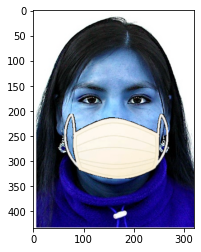

In [119]:
s_img = cv2.imread("./data/mask.png")
s_img = imutils.resize(s_img, width=width, height=height)
s_img = imutils.rotate_bound(s_img, angle)

rows = [i for i, row in enumerate(s_img) if row.sum() == 0]
columns = [i for i, col in enumerate(s_img.transpose(1, 0, 2)) if col.sum() == 0]
        
s_img = np.delete(s_img, [rows], 0)
s_img = np.delete(s_img.transpose(1, 0, 2), [columns], 0)
s_img = s_img.transpose(1, 0, 2)

x_offset=shape[51][0] - int(s_img.shape[1]/2)
y_offset=shape[51][1] - int(s_img.shape[0]/2)

y1, y2 = y_offset, y_offset + s_img.shape[0]
x1, x2 = x_offset, x_offset + s_img.shape[1]

y1 = max(0, y1)
x1 = max(0, x1)
y2 = min(l_img.shape[0]-1, y2)
x2 = min(l_img.shape[1]-1, x2)

for y in range(y1, y2):
    for x in range(x1, x2):
        l_img[y, x] = s_img[y-y1, x-x1] if sum(s_img[y-y1, x-x1]) != 0 else l_img[y, x]
        
plt.imshow(l_img)

In [108]:
l_img = cv2.imread('./data/face.jpg')

In [109]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
gray = cv2.cvtColor(l_img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)
shape = predictor(gray, rects[0])
shape = face_utils.shape_to_np(shape)
coords = shape[[0, 8, 16]]
diff = coords[2] - coords[0]
width = int(sum((diff) ** 2) ** (1/2))
mid = (coords[0] + coords[2]) / 2
height = int(sum((mid - coords[1]) ** 2) ** (1/2))
angle = np.degrees(np.arctan2(diff[1], diff[0]))

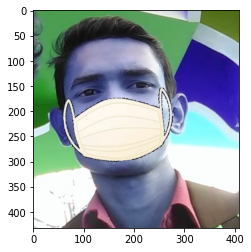

In [110]:
s_img = cv2.imread("./data/mask.png")
s_img = imutils.resize(s_img, width=width, height=height)
s_img = imutils.rotate_bound(s_img, angle)

rows = [i for i, row in enumerate(s_img) if row.sum() == 0]
columns = [i for i, col in enumerate(s_img.transpose(1, 0, 2)) if col.sum() == 0]
        
s_img = np.delete(s_img, [rows], 0)
s_img = np.delete(s_img.transpose(1, 0, 2), [columns], 0)
s_img = s_img.transpose(1, 0, 2)

x_offset=shape[51][0] - int(s_img.shape[1]/2)
y_offset=shape[51][1] - int(s_img.shape[0]/2)

y1, y2 = y_offset, y_offset + s_img.shape[0]
x1, x2 = x_offset, x_offset + s_img.shape[1]

y1 = max(0, y1)
x1 = max(0, x1)
y2 = min(l_img.shape[0]-1, y2)
x2 = min(l_img.shape[1]-1, x2)

for y in range(y1, y2):
    for x in range(x1, x2):
        l_img[y, x] = s_img[y-y1, x-x1] if sum(s_img[y-y1, x-x1]) != 0 else l_img[y, x]
        
plt.imshow(l_img)

In [16]:
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # show the face number
    cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
        
    
# show the output image with the face detections + facial landmarks
cv2.imshow("Output", image)
cv2.waitKey(0)

QObject::moveToThread: Current thread (0x5635cce99c50) is not the object's thread (0x5635ccffc4c0).
Cannot move to target thread (0x5635cce99c50)

QObject::moveToThread: Current thread (0x5635cce99c50) is not the object's thread (0x5635ccffc4c0).
Cannot move to target thread (0x5635cce99c50)

QObject::moveToThread: Current thread (0x5635cce99c50) is not the object's thread (0x5635ccffc4c0).
Cannot move to target thread (0x5635cce99c50)

QObject::moveToThread: Current thread (0x5635cce99c50) is not the object's thread (0x5635ccffc4c0).
Cannot move to target thread (0x5635cce99c50)

QObject::moveToThread: Current thread (0x5635cce99c50) is not the object's thread (0x5635ccffc4c0).
Cannot move to target thread (0x5635cce99c50)

QObject::moveToThread: Current thread (0x5635cce99c50) is not the object's thread (0x5635ccffc4c0).
Cannot move to target thread (0x5635cce99c50)

QObject::moveToThread: Current thread (0x5635cce99c50) is not the object's thread (0x5635ccffc4c0).
Cannot move to tar

113

In [ ]:
# compute the (x, y)-coordinates of the bounding box for the face
box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
(startX, startY, endX, endY) = box.astype("int")
# construct a dlib rectangle object from our bounding box coordinates
# and then determine the facial landmarks for the face region
rect = dlib.rectangle(int(startX), int(startY), int(endX), int(endY))
shape = predictor(image, rect)
shape = face_utils.shape_to_np(shape)
# grab the indexes of the facial landmarks for the left and right
# eye, respectively, then extract (x, y)-coordinates for each eye
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
leftEyePts = shape[lStart:lEnd]
rightEyePts = shape[rStart:rEnd]